In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Importing Necessary Modules 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.cluster import KMeans
import datetime
from datetime import date, timedelta
import folium
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [ ]:
t_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv")

In [ ]:
DATA = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")

In [ ]:
t_data.head(5)

In [ ]:
t_data.shape

In [ ]:
#for India
data_In = t_data[t_data['country']=='India']
data_In.shape

In [ ]:
plt.figure(figsize = (20, 5))
plt.title("Gender")
t_data.sex.value_counts().plot.bar();

In [ ]:
t_data.isna().sum()

Getting % of Null values in Respective columns

In [ ]:
NAN = [(i, t_data[i].isna().mean()*100) for i in t_data]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN

In [ ]:
t_data.describe().T

In [ ]:
NAN = [(i, DATA[i].isna().mean()*100) for i in DATA]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN

Filling "Unknown" in "Province" column where value is null

In [ ]:
DATA["Province/State"] = DATA["Province/State"].fillna('Unknown')

In [ ]:
DATA[["Confirmed", "Deaths", "Recovered"]] = DATA[["Confirmed", "Deaths", "Recovered"]].astype(int)

In [ ]:
DATA.head()

In [ ]:
DATA['Active'] = DATA['Confirmed'] - DATA['Deaths'] - DATA['Recovered']
DATA.head()

**Overall Effect**

In [ ]:
DATA_W = DATA[DATA['ObservationDate'] == max(DATA['ObservationDate'])].reset_index()

In [ ]:
Data = DATA_W.groupby(["ObservationDate"])["Confirmed","Active","Recovered","Deaths"].sum().reset_index()
Data

In [44]:
labels = ["Active cases","Recovered","Deaths"]
values = Data.loc[0, ["Active","Recovered","Deaths"]]
fig = px.pie(Data, values=values, names=labels, color_discrete_sequence=['red','lightgreen','darkblue'])
fig.update_layout(
    title= 'Total cases : '+str(Data["Confirmed"][0]),
)
fig.show()

Country-Wise Cases

In [ ]:
Country_data = DATA_W.groupby(["Country/Region"])["Confirmed"].sum().reset_index().sort_values("Confirmed",ascending=False).reset_index(drop=True)
Country_data

**Effect In India**

In [ ]:
Data_Ind = DATA[(DATA['Country/Region'] == 'India') ].reset_index(drop=True)
Data_Ind

In [ ]:
Data_ind = Data_Ind.groupby(["ObservationDate"])["Confirmed","Active","Recovered","Deaths"].sum().reset_index()
Data_ind

Latest Update

In [ ]:
Data_ind_last = Data_ind[Data_ind['ObservationDate'] == max(Data_ind['ObservationDate'])].reset_index()

In [ ]:
labels = ["Active case", "Recoverd", "Deaths"]
values = Data_ind_last.loc[0, ["Active","Recovered","Deaths"]]
df = px.data.tips()
fig = px.pie(Data_ind_last, values=values, names=labels, color_discrete_sequence=['red','lightgreen','darkblue'])
fig.update_layout(
    title='Total cases : '+str(Data_ind_last["Confirmed"][0]),
)
fig.show()

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = Data_ind['ObservationDate'], y = Data_ind['Confirmed'], mode='lines',
                    name='Confirmed cases',marker_color='green'))
fig.add_trace(go.Scatter(x=Data_ind['ObservationDate'], y=Data_ind['Active'], marker_color='darkgrey',mode='lines',
                    name='Active cases',line=dict( dash='dot')))

fig.add_trace(go.Scatter(x=Data_ind['ObservationDate'], y=Data_ind['Deaths'],name='Deaths',
                                   marker_color='red',mode='lines',line=dict( dash='dot') ))
fig.add_trace(go.Scatter(x=Data_ind['ObservationDate'], y=Data_ind['Recovered'], mode='lines',
                    name='Recovered cases',marker_color='blue'))

fig.update_layout(title='Case Progress in India',
)
fig.show()

Applying KMeans for clustering

In [ ]:
cluster=Data_ind.loc[:,['id','Active','Confirmed']]
cluster.head(5)

In [42]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(cluster[cluster.columns[1:3]])
cluster['cluster_label'] = kmeans.fit_predict(cluster[cluster.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(cluster[cluster.columns[1:3]])

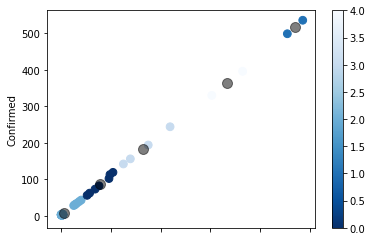

In [43]:
cluster.plot.scatter(x = 'Active', y = 'Confirmed', c=labels, s=60, cmap='Blues_r')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)